In [30]:
import pandas as pd
import os
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set_theme(style="darkgrid")

# **DONT CHANGE ANYTHING (The data is nice already, good accuracy)**

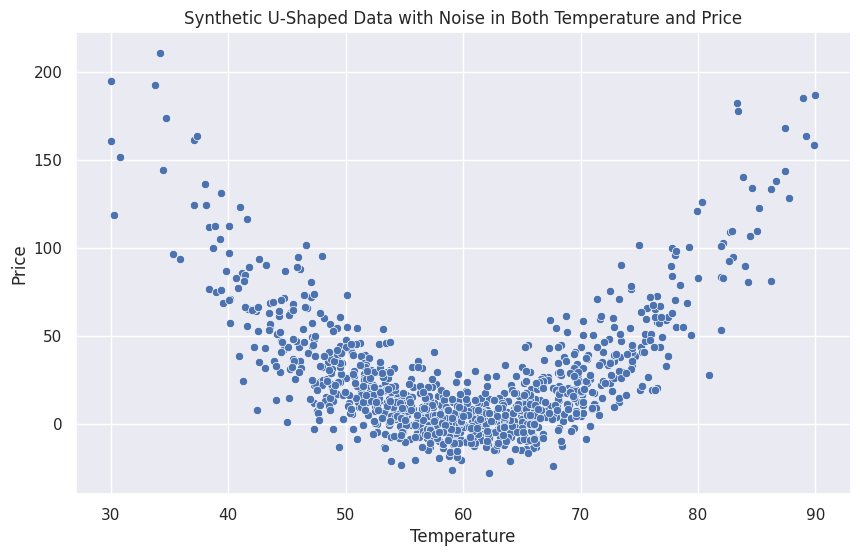

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm

# Parameters for the U-shaped baseline function
med = 60      # Temperature at which the price is minimized
a = 1/4       # Controls the curvature of the U-shape
b = 0         # Offset (can be adjusted if needed)

# Number of data points to simulate
num_points = 1000

# --- Using a Truncated Normal Distribution for Temperature ---
# We want temperatures to be more concentrated around 60°F.
# Define the parameters for the truncated normal:
mu = 60           # Mean centered at 60°F
sigma = 10        # Standard deviation (adjust to control the spread)
lower = 30        # Minimum temperature
upper = 90        # Maximum temperature

# For scipy's truncnorm, calculate the "a" and "b" parameters:
a_val = (lower - mu) / sigma  # e.g., (30 - 60) / 20 = -1.5
b_val = (upper - mu) / sigma  # e.g., (90 - 60) / 20 = 1.5

# Sample temperatures from the truncated normal distribution:
temps = truncnorm.rvs(a_val, b_val, loc=mu, scale=sigma, size=num_points)

# --- Add Additional Noise (Jitter) to the Temperature Values ---
# This extra noise simulates measurement errors or day-to-day variability.
temp_jitter = np.random.normal(0, 3, num_points)  # Adjust std as desired
temps_noisy = temps + temp_jitter

# Optionally, clip the noisy temperatures to ensure they remain within the bounds.
temps_noisy = np.clip(temps_noisy, lower, upper)

# --- Compute the Baseline Price from the U-Shaped Function ---
# Here we use the ideal (non-jittered) temperature for the baseline function.
# Alternatively, you could choose to use temps_noisy if you want the noise to affect the trend as well.
prices_baseline = a * (temps - med)**2 + b

# --- Add Realistic Gaussian Noise to the Price ---
price_noise = np.random.normal(0, 10, num_points)  # noise with standard deviation 10
prices = prices_baseline + price_noise

# --- Create the DataFrame ---
df = pd.DataFrame({"Temp": temps_noisy, "Price": prices})

# --- Plot the Data ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Temp", y="Price")
plt.xlabel("Temperature")
plt.ylabel("Price")
plt.title("Synthetic U-Shaped Data with Noise in Both Temperature and Price")
plt.show()


<Axes: xlabel='Date', ylabel='simTemp'>

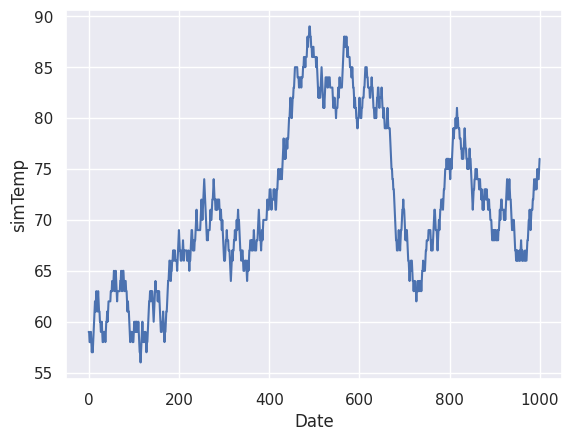

In [124]:
dates = []
simTemps = []
curr_value = 60
for date in range(0,1000):
    if curr_value > 100:
        curr_value -= 1
    else:
        curr_value = curr_value + rand.randint(-1, 1)
    dates.append(date)
    simTemps.append(curr_value)

sim_df = pd.DataFrame({"Date": dates, "simTemp": simTemps})
sns.lineplot(sim_df, x="Date", y = "simTemp")

In [125]:
# First, sort df by temperature:
df_sorted = df.sort_values("Temp")

# Use np.interp to create a smooth mapping from simTemp to Price.
# np.interp(x, xp, fp) returns the interpolated value at x,
# given that the points xp correspond to the values fp.
sim_df["Pred_Price"] = np.interp(sim_df["simTemp"],
                                 df_sorted["Temp"],
                                 df_sorted["Price"])


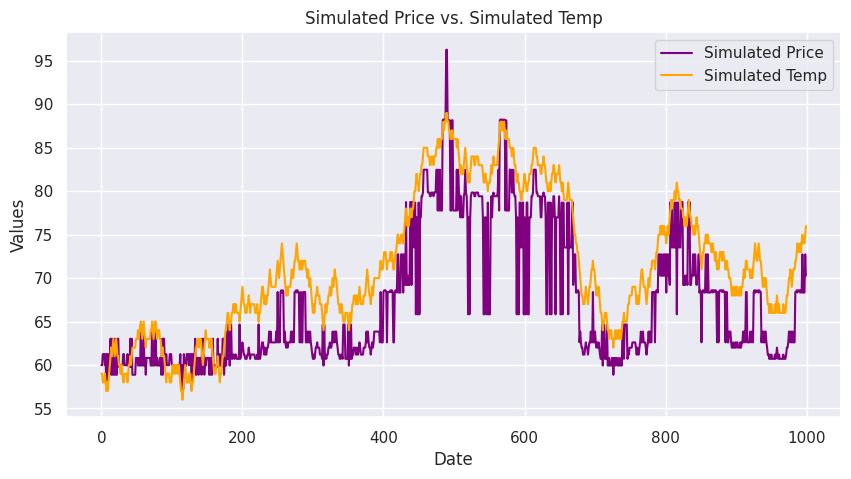

In [131]:
plt.figure(figsize=(10, 5))

# Plot both lines on the same axis
sns.lineplot(data=sim_df, x="Date", y=sim_df["Pred_Price"]*(1/5)+60, label="Simulated Price", color="purple")
sns.lineplot(data=sim_df, x="Date", y="simTemp", label="Simulated Temp", color="orange")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Simulated Price vs. Simulated Temp")
plt.legend()

# Show the plot
plt.show()

In [35]:
## EVERTHING ABOVE THIS IS JUST GETTING THE TRAINING/TEST DATA (sim_df)

In [36]:
## EVERYTHING BELOW IS MACHINE LEARNING

In [37]:
# Random Forest

Feature matrix shape (X): (979, 35)
Target vector shape (y): (979,)
Training samples: 685
Testing samples: 294
Test Mean Squared Error (MSE): 114.21


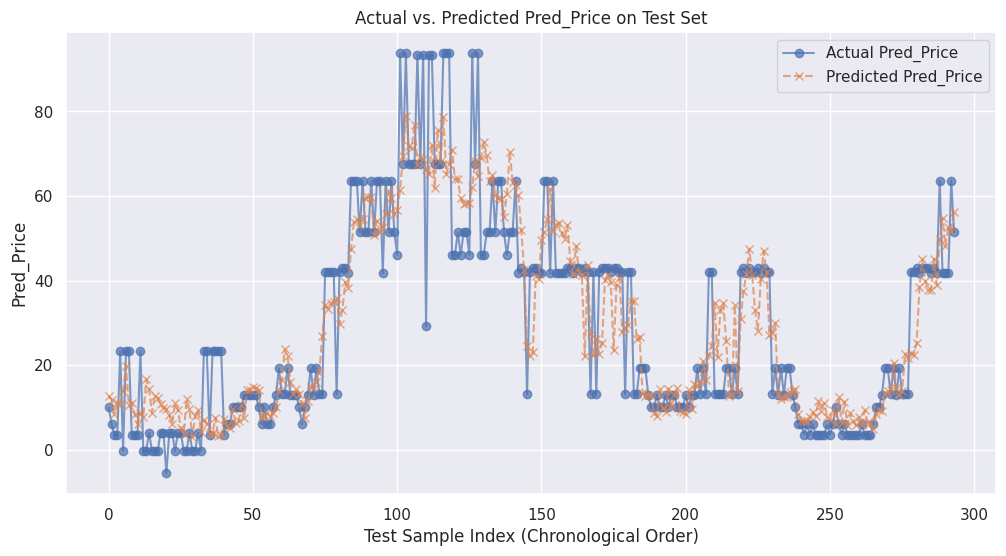

In [132]:
# --- Step 0: Import libraries (if not already imported) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# --- Step 1: Prepare the simulated DataFrame ---
# (Assume sim_df is already created from your hackathon code and has the columns:
#  "Date", "simTemp", and "Pred_Price".)
# Ensure the DataFrame is sorted by time.
sim_df = sim_df.sort_values(by="Date").reset_index(drop=True)

# --- Step 2: Define the sliding-window parameters ---
# We use 14 days (history) for both simTemp and Pred_Price, and
# the next 7 days of simTemp as the future known weather.
window_history = 14  # past 14 days of simTemp and Pred_Price
window_forecast = 7   # next 7 days of simTemp (forecast) and target at t+7

# --- Step 3: Build the feature matrix and target vector ---
# For each valid time t (i.e. where there is enough past and future data):
#   - Features will be: [past 14 days of simTemp, past 14 days of Pred_Price, next 7 days of simTemp]
#   - Target will be: Pred_Price at t+7
features_list = []
target_list = []

# We iterate from index 'window_history' up to 'len(sim_df) - window_forecast'
for t in range(window_history, len(sim_df) - window_forecast):
    # Past 14 days of simulated temperature (simTemp)
    past_simtemp = sim_df["simTemp"].iloc[t - window_history:t].values
    # Past 14 days of predicted price (Pred_Price)
    past_pred_price = sim_df["Pred_Price"].iloc[t - window_history:t].values
    # Next 7 days of simulated temperature (assumed known)
    future_simtemp = sim_df["simTemp"].iloc[t:t + window_forecast].values

    # Combine these into one feature vector.
    # (The order here is: first the past simTemp, then past Pred_Price, then future simTemp.)
    features = np.concatenate([past_simtemp, past_pred_price, future_simtemp])
    features_list.append(features)

    # The target is the predicted price 7 days ahead (at t + window_forecast)
    target = sim_df["Pred_Price"].iloc[t + window_forecast]
    target_list.append(target)

# Convert the lists into numpy arrays.
X = np.array(features_list)  # Each sample has 14 + 14 + 7 = 35 features.
y = np.array(target_list)

print("Feature matrix shape (X):", X.shape)
print("Target vector shape (y):", y.shape)

# --- Step 4: Chronologically split the dataset (70% train, 30% test) ---
# Since this is time series data, we split without shuffling.
split_index = int(0.7 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- Step 5: Train the machine learning model ---
# We use a Random Forest Regressor here as an example.
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 6: Evaluate the model on the test set ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {mse:.2f}")

# --- Step 7: Plot Actual vs. Predicted Pred_Price ---
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Pred_Price", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred, label="Predicted Pred_Price", marker='x', linestyle='--', alpha=0.7)
plt.xlabel("Test Sample Index (Chronological Order)")
plt.ylabel("Pred_Price")
plt.title("Actual vs. Predicted Pred_Price on Test Set")
plt.legend()
plt.show()


In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Assume y_test are your true values and y_pred are the predictions from your model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# For MAPE, be cautious with zeros in y_test
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by adding a small number if needed
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared: {r2:.2f}")
print(f"Explained Variance Score: {explained_var:.2f}")


Mean Squared Error (MSE): 114.21
Root Mean Squared Error (RMSE): 10.69
Mean Absolute Error (MAE): 7.93
Mean Absolute Percentage Error (MAPE): 165.26%
R-squared: 0.80
Explained Variance Score: 0.80


In [40]:
# XG Boost

XGBoost Model Performance:
Mean Squared Error (MSE): 125.56
Root Mean Squared Error (RMSE): 11.21
Mean Absolute Error (MAE): 8.14
R-squared: 0.78


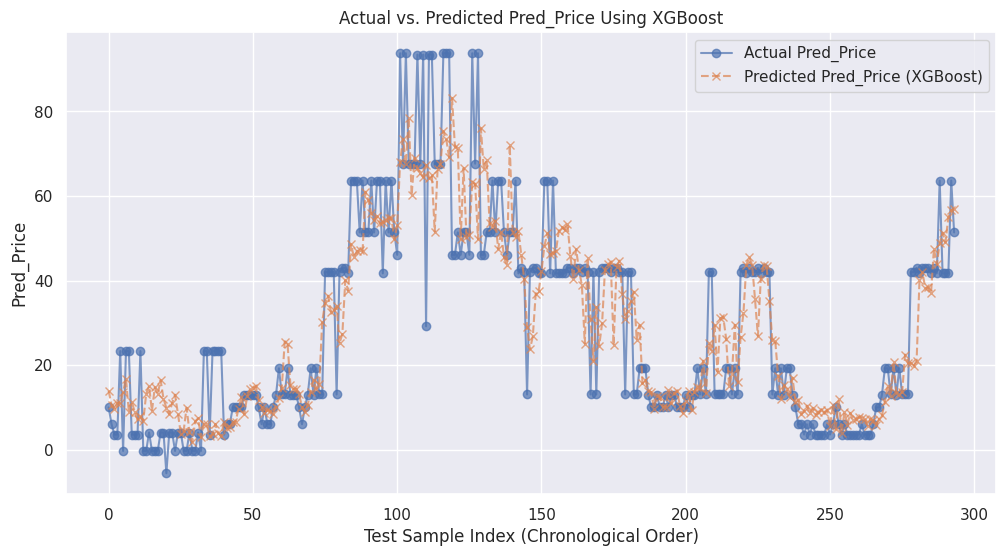

In [130]:
# --- Step 0: Import Necessary Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import the XGBoost regressor (make sure you've installed xgboost via pip if not already installed)
from xgboost import XGBRegressor

# --- Step 1: Assume You Already Have Your Data Prepared ---
# For example, assume X_train, X_test, y_train, y_test are already created from your sliding-window process.
# (If not, please refer to the previous code to create them from your sim_df.)

# --- Step 2: Instantiate the XGBoost Model with Chosen Hyperparameters ---
# Here we set:
# - n_estimators=100: The number of boosting rounds (trees) to build.
# - learning_rate=0.1: The step size shrinkage used to prevent overfitting.
# - max_depth=5: The maximum depth of each tree, controlling model complexity.
# - random_state=42: Ensures reproducibility.
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# --- Step 3: Train the Model on the Training Data ---
model_xgb.fit(X_train, y_train)

# --- Step 4: Make Predictions on the Test Data ---
y_pred_xgb = model_xgb.predict(X_test)

# --- Step 5: Evaluate the Model Using Common Regression Metrics ---
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r2:.2f}")

# --- Optional: Plot Actual vs. Predicted Values for Visual Comparison ---
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Pred_Price", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_xgb, label="Predicted Pred_Price (XGBoost)", marker='x', linestyle='--', alpha=0.7)
plt.xlabel("Test Sample Index (Chronological Order)")
plt.ylabel("Pred_Price")
plt.title("Actual vs. Predicted Pred_Price Using XGBoost")
plt.legend()
plt.show()
